In [1]:
import pandas as pd
tweets = pd.read_csv("/media/alessandro/storage/Tesi/locale/twitter-sentiment-analysis2/train.csv", encoding='latin-1')
list(tweets.columns.values)

['ItemID', 'Sentiment', 'SentimentText']

In [2]:
tweets.Sentiment.replace(0,'negative', inplace=True)
tweets.Sentiment.replace(1,'positive', inplace=True)

tweets.head()

,ItemID,Sentiment,SentimentText
0,1,negative,is so sad for my APL frie...
1,2,negative,I missed the New Moon trail...
2,3,positive,omg its already 7:30 :O
3,4,negative,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,negative,i think mi bf is cheating on me!!! ...


0 -> negative 

In [3]:
sentiment_counts = tweets.Sentiment.value_counts()
number_of_tweets = tweets.ItemID.count()
print(sentiment_counts)

positive    56457
negative    43532
Name: Sentiment, dtype: int64


In [4]:
# import nltk
# nltk.download('wordnet')

In [5]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [6]:
normalizer("Here is text about an airline I like.")

['text', 'airline', 'like']

In [7]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets['normalized_tweet'] = tweets.SentimentText.apply(normalizer)
tweets[['SentimentText','normalized_tweet']].head()

,SentimentText,normalized_tweet
0,is so sad for my APL friend.............,"[sad, apl, friend]"
1,I missed the New Moon trailer...,"[new, moon, trailer]"
2,omg its already 7:30 :O,[already]
3,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,"[sooo, im, gunna, cry, dentist, since, suposed, get, crown, put, min]"
4,i think mi bf is cheating on me!!! T_T,"[mi, bf, cheating]"


In [10]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
0,"[sad apl, apl friend, sad apl friend]"
1,"[new moon, moon trailer, new moon trailer]"
2,[]
3,"[sooo im, im gunna, gunna cry, cry dentist, dentist since, since suposed, suposed get, get crown, crown put, put min, sooo im gunna, im gunna cry, gunna cry dentist, cry dentist since, dentist since suposed, since suposed get, suposed get crown, get crown put, crown put min]"
4,"[mi bf, bf cheating, mi bf cheating]"


In [11]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [12]:
tweets[(tweets.Sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(20)

[('gon na', 587),
 ('wan na', 531),
 ('wish could', 308),
 ('last night', 300),
 ('twitpic com', 262),
 ('got ta', 223),
 ('sorry hear', 194),
 ('feel better', 187),
 ('bit ly', 186),
 ('look like', 184),
 ('feel like', 182),
 ('http bit', 168),
 ('http bit ly', 166),
 ('na go', 150),
 ('oh well', 132),
 ('want go', 126),
 ('next week', 113),
 ('miss u', 110),
 ('get better', 109),
 ('make sad', 105)]

In [13]:
tweets[(tweets.Sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(20)

[('twitpic com', 658),
 ('gon na', 527),
 ('bit ly', 444),
 ('http bit', 395),
 ('http bit ly', 395),
 ('wan na', 307),
 ('good luck', 236),
 ('last night', 221),
 ('tinyurl com', 212),
 ('got ta', 210),
 ('let know', 208),
 ('quot quot', 207),
 ('http tinyurl', 202),
 ('http tinyurl com', 200),
 ('com add', 184),
 ('day using', 182),
 ('using www', 182),
 ('add everyone', 182),
 ('everyone train', 182),
 ('train pay', 182)]

In [14]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [15]:
vectorized_data = count_vectorizer.fit_transform(tweets.SentimentText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [16]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.Sentiment.apply(sentiment2target)

In [17]:
targets.head(5)

0    0
1    0
2    2
3    0
4    0
Name: Sentiment, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

In [19]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

In [21]:
clf.score(data_test, targets_test)

0.7534753475347534

In [24]:
import pickle
# save the classifier
with open('SVM.pkl', 'wb') as fid:
    pickle.dump(clf, fid)    

# # load it again
# with open('my_dumped_classifier.pkl', 'rb') as fid:
#     gnb_loaded = pickle.load(fid)

In [25]:
with open('vectorizer.pkl', 'wb') as fid:
    pickle.dump(count_vectorizer, fid)
    
# # load it again
# with open('vectorizer.pkl', 'rb') as fid:
#     vectorizer = pickle.load(fid)    

In [28]:
se = count_vectorizer.transform(["Trump is the worst president ever, but the sun is still awesome!"])
clf.predict_proba(se)

array([[0.21785285, 0.78214715]])

In [29]:
se = count_vectorizer.transform(["Trump is the worst president ever"])
clf.predict_proba(se)

array([[0.75423658, 0.24576342]])

In [30]:
se = count_vectorizer.transform(["Trump is the best president ever"])
clf.predict_proba(se)

array([[0.44759613, 0.55240387]])

In [38]:
se = count_vectorizer.transform(["Sun is awesome"])
clf.predict_proba(se)

array([[0.04915123, 0.95084877]])

In [27]:
import tweepy
from pymongo import MongoClient


df = pd.read_csv('authority-modularity.csv')
df=df.drop(['Label','timeset','Hub'],axis=1)

indexNames = df[ (df.modularity_class != 11) & (df.modularity_class != 9) & (df.modularity_class != 4) ].index
df.drop(indexNames , inplace=True)

df.modularity_class.value_counts()

first10_cl11=df[df.modularity_class == 11].sort_values('Authority', ascending=False).head(10)
first10_cl4=df[df.modularity_class == 4].sort_values('Authority', ascending=False).head(10)
first10_cl9=df[df.modularity_class == 9].sort_values('Authority', ascending=False).head(10)

utenti_cl11=first10_cl11.Id.tolist()
utenti_cl4=first10_cl4.Id.tolist()
utenti_cl9=first10_cl9.Id.tolist()

utenti_final= utenti_cl11+utenti_cl4+utenti_cl9


ACCESS_TOKEN = '1089903781880434688-SDhXR2aBBr54lZQ8QnPaE4mUR6TrOd'
ACCESS_SECRET = 'D6wHvFEmbL3W0FSP70jxBRpIYs53UGxuQlQ5yHf578ZDt'
CONSUMER_KEY = 'kGR5GYd09tSmQCJeyprOKlKeV'
CONSUMER_SECRET = 'MNeyyl0SkUOGgkIs8kDdZktPi2HCxC7mTv6re4GywsiarZDR3c'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) 
  
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET) 

api = tweepy.API(auth)


from datetime import timedelta, datetime

for idx, utente in enumerate(utenti_final):
    try:
        last_tweet = api.user_timeline(user_id=utente, count=1) 
        created_at = last_tweet[0].created_at
    
        if (created_at > datetime.now() - timedelta(days=90)):
            print('{}: this user is still active: {}\tlast post: {}'.format(idx,utente,created_at))
        else:
            utenti_final.remove(utente)
            print('inactive user {} droppato'.format(utente))
                
    except Exception as err:
        print(err)
        utenti_final.remove(utente)
        print('inactive user {} droppato'.format(utente))
        continue
        
        
client = MongoClient('localhost', 27017)
db = client['twitter']

data = pd.DataFrame(columns=['Tweets'])

for user in utenti_final:
    
    print('colleziono tweet utente numero:', user)

    pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1}}, { "$match": {  "id_user" : user} }]

    cursor_list = list(db['tweets'].aggregate(pipeline))

    tweets = pd.DataFrame(cursor_list)
    data=data.append(tweets, sort=True)

dfAll = pd.DataFrame(data.originalTweet)

Not authorized.
inactive user 123926189 droppato
1: this user is still active: 52456063	last post: 2019-09-19 13:20:56
2: this user is still active: 18119568	last post: 2019-09-19 11:30:37
3: this user is still active: 14872161	last post: 2019-09-19 06:24:59
4: this user is still active: 10236782	last post: 2019-09-19 13:44:36
5: this user is still active: 45762728	last post: 2019-09-17 01:08:22
6: this user is still active: 175339579	last post: 2019-09-19 12:01:01
7: this user is still active: 171656520	last post: 2019-09-19 13:58:27
8: this user is still active: 21765964	last post: 2019-09-19 13:58:51
Not authorized.
inactive user 15773072 droppato
inactive user 42919671 droppato
11: this user is still active: 54292369	last post: 2019-09-18 04:16:14
12: this user is still active: 18084838	last post: 2019-09-19 03:35:45
13: this user is still active: 41823835	last post: 2019-09-19 07:49:09
14: this user is still active: 94853291	last post: 2019-09-19 11:08:13
15: this user is still ac

In [32]:
trumpTweet = dfAll[dfAll.originalTweet.str.contains("(?:^|\W)#Trump(?:$|\W)|\
                                                (?:^|\W)#DonaldTrump(?:$|\W)|\
                                                (?:^|\W)#trump(?:$|\W)|\
                                                (?:^|\W)@realDonaldTrump(?:$|\W)\
                                                (?:^|\W)#donaldtrump(?:$|\W)\
                                                (?:^|\W)Trump(?:$|\W)|\
                                                (?:^|\W)DonaldTrump(?:$|\W)|\
                                                (?:^|\W)trump(?:$|\W)|\
                                                (?:^|\W)realDonaldTrump(?:$|\W)\
                                                (?:^|\W)donaldtrump(?:$|\W)")]

In [33]:
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply(lambda x: x.lower())
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

for idx,row in trumpTweet.iterrows():
    row[0] = row[0].replace('rt',' ')

/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
counts = {}
counts['positive']=0
counts['negative']=0


for twt in trumpTweet.originalTweet:

    twt = [twt]
    twt = count_vectorizer.transform(twt)
    sentiment = clf.predict_proba(twt)
    
    if sentiment[0][0] <= sentiment[0][1]:
        counts["positive"]+=1
    else:
        counts["negative"]+=1

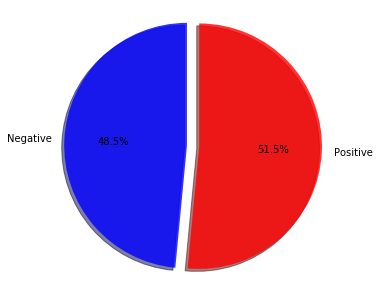

In [45]:
import matplotlib
import matplotlib.pyplot as plt

sizes = [counts['negative'], counts['positive']]
explode = (0, 0.1)
labels = 'Negative', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="br", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()